# 3. European Options Pricing

In [4]:
# import all stuff we will need
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.datasets

from numpy.random import randn
from scipy.stats import norm
from scipy.optimize import fmin_slsqp
from scipy.optimize import fsolve
from scipy.interpolate import UnivariateSpline
from call_put_bs import call_put_bs
from min_max import min_max
from implied_vola import implied_vola
from mle_tlocation import mle_tlocation
from scipy.special import gamma
from yf import yf

## 3.1. Black Scholes Model

The Black-Scholes formula with: ($\omega=1$ for a call, $\omega=-1$ for a put)

\begin{equation*}
V(s,t;X,T,\sigma,r,q,\omega)=\omega\big(se^{-q(T-t)}N(\omega d_1)-Xe^{-r(T-t)}N(\omega d_2)\big)\;.
\end{equation*}

The model- and contract parameters are from chapter 1. In particular $s_0=286.10$, $T=358/360$, $J=252$, $\sigma=0.0753$, $r=-0.0063$ and $q=0.0310$. Thus

In [7]:
s0 = 286.1; T = 358/360; J = 252; sigma = 0.0753; r = -0.0063; q = 0.0310; # model- and contract parameters
min_max(s0,sigma,r,q,T,J,1,1,10**6)

33.72233025986402

## 3.2. Calculate Implied Volatility

We calculate the implied volatility of the call option with strike $X = 76$ and market price $V^{\rm M} = 6.23$. Since there holds $s = 77.45$, $T − t = 99/360$, $r = -0.0081$ and $q = 0$ we find:

In [8]:
s = 77.45; # the price of the underlying
T = yf((11,9,2019),[(20,12,2019)])[0]; r = -0.0081; q = 0; # time-to-maturity, cc risk-free
implied_vola(6.23,s,76,T,r,q,1,0.5)

0.3468833779533675

## 3.3. Case Study

In [3]:
# download option data for U-Blox: data as of September 11, 2019
#df = pd.read_html('https://www.eurexchange.com/exchange-en/market-data/statistics/market-statistics-online/100!onlineStats?productGroupId=9772&productId=1597674&viewType=3&cp=Call&month=12&year=2019&busDate=20190911')
# save the downloaded data
#df = df[0]; df = df[:-1]; df.to_pickle("ublox") 

# load the downloaded data
path= r'D:/Venvs/Finance/Options-Pricing-Model/docs/Jupiter-Notebooks-Python-functions/'
df= pd.read_pickle(path + "ublox")
df

,Strike price,Version number,Opening price,Daily high,Daily low,Last price,Daily settlem. price,Traded contracts,Open interest,Open interest (adj.)
0,0.01,0.0,0.0,0.0,0.0,0.0,77.44,0,0,0
1,48.00,0.0,0.0,0.0,0.0,0.0,29.57,0,0,0
2,50.00,0.0,0.0,0.0,0.0,0.0,27.62,0,0,0
3,52.00,0.0,0.0,0.0,0.0,0.0,25.67,0,0,0
4,56.00,0.0,0.0,0.0,0.0,0.0,21.88,0,0,0
5,60.00,0.0,0.0,0.0,0.0,0.0,18.21,0,0,0
6,64.00,0.0,0.0,0.0,0.0,0.0,14.73,0,0,0
7,68.00,0.0,0.0,0.0,0.0,0.0,11.51,0,4,4
8,72.00,0.0,0.0,0.0,0.0,0.0,8.66,0,0,0
9,76.00,0.0,0.0,0.0,0.0,0.0,6.23,0,0,0


In [5]:
df = df[['Strike price','Daily settlem. price']].astype(float)
D = df.values
D = D[D[:,0]>=1] # do not take all values to fit the model
X = D[:,0]; VM = D[:,1]

Find the implied volatilities for the options in df.

In [9]:
vola_i = np.zeros(len(D))
vola_i[0] = implied_vola(D[0,1],s,D[0,0],T,r,q,1,0.6);
for j in range(1,len(D)):
    vola_i[j] = implied_vola(VM[j],s,X[j],T,r,q,1,vola_i[j-1]);

vola_i

array([0.50370862, 0.48556632, 0.46447264, 0.43892689, 0.41479637,
       0.39377892, 0.37492644, 0.36004817, 0.34688338, 0.33817546,
       0.33619289, 0.33769768, 0.34224473, 0.34779472])

Now plot the points $(X_\ell,\sigma_\ell^{\rm i})$. 

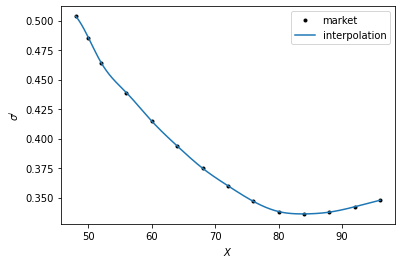

In [10]:
plt.plot(X,vola_i,'k.'); 

f = UnivariateSpline(X,vola_i,k=3,s=0); 
Xvec = np.arange(np.min(X),np.max(X)+0.01,0.01)

plt.plot(Xvec,f(Xvec));
plt.xlabel('$X$'); plt.ylabel('$\sigma^i$');
plt.legend(('market','interpolation'));

Check the butterfly-arbitrage condition $\partial_{XX}V\geq 0$ for the above data.

In [11]:
V = lambda x:call_put_bs(s,x,T,f(x),r,q,1) # the option price V; for later purpose

f_x = f.derivative(1); f_xx = f.derivative(2) # the derivatives of f

# get the aux function chi(X)
d1 = lambda x:(np.log(s/x)+(r-q+f(x)**2/2)*T)/(f(x)*np.sqrt(T))
d2 = lambda x:d1(x)-f(x)*np.sqrt(T)
chi = lambda x:2*np.sqrt(T)*x*d1(x)*f_x(x)+T*d1(x)*d2(x)*x**2*f_x(x)**2+T*x**2*f(x)*f_xx(x)

# get the dual-gamma
V_XX = lambda x:np.exp(-r*T)*norm.pdf(d2(x))/(x*f(x)*np.sqrt(T))*(1+chi(x))

5.470369325280785

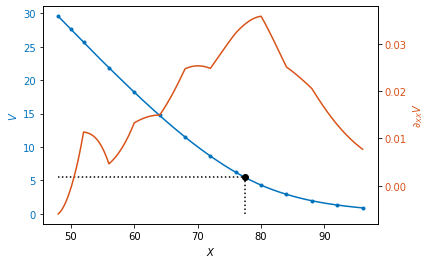

In [12]:
# plot option price and its dual-gamma
fig, ax1 = plt.subplots()
color = (0,0.4470,0.7410)
ax1.plot(Xvec,V(Xvec),color=color), ax1.plot(X,VM,'.',color=color)
ax1.plot([s,s,np.min(X)],[0,V(s),V(s)],'k:'), ax1.plot(s,V(s),'ko')
ax1.set_xlabel('$X$'), ax1.set_ylabel('$V$',color=color)
ax1.tick_params(axis='y',labelcolor=color)

ax2 = ax1.twinx()

color = (0.85,0.325,0.098)
ax2.plot(Xvec,V_XX(Xvec),color=color);
ax2.set_ylabel('$\partial_{XX}V$',color=color)
ax2.tick_params(axis='y',labelcolor=color)

V(s) # the value of a ATM call according to the 'model' f

As we have calibrated the model $w$ to market quotes, we are able to solve the problem of example 1.1, iii): On September 11, 2019 ($t=0$) find the strike $X$ of a European call option on U-Blox which expires on December 20, 2019 $(t=T)$ such that $V_c(s,0;X)=2.75$. 

Now we repeat drawing the profit diagram of the outperformance product in example 1.1, iii).

In [17]:
# find the strike X such that Vc(s;X) - 2.75 = 0
f = lambda x: call_put_bs(s,x,T,g(x),r,q,1)[0]
X2 = fsolve(lambda x:f(x)-2.75,80)[0]

X2

NameError: name 'w_model' is not defined

In [16]:
# the implied vola and the price of calls with strike X1 and X2, respectively
X1 = 1.0*s; x = np.asarray([[X1,X2]])
prices = call_put_bs(s,x,T,g(x),r,q,1)[0]
g(x), prices

NameError: name 'X2' is not defined

In [ ]:
n_long = 1; n_short = 2; # 'n_long' long call with strike X1, 'n_short' short call with strike X2

# draw the profit diagram of the outperformance product
V0 = s+n_long*prices[0]-n_short*prices[1]
profit = lambda x,X1,X2,V0: x+n_long*np.maximum(x-X1,0)-n_short*np.maximum(x-X2,0)-V0;
x = np.arange(0.8*s,1.2*s,0.1);
plt.plot(x,profit(x,X1,X2,V0)); plt.plot(x,x-s);
plt.plot(x,-n_short*np.maximum(x-X2,0)+n_short*prices[1]);
plt.plot(x,n_long*np.maximum(x-X1,0)-n_long*prices[0]); plt.grid()
plt.legend(['product','long ul','short %i call' %n_short,'long %i call'%n_long])
plt.xlabel('$S_T$'), plt.ylabel('$P$');